# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [ ]:
import sys
sys.path.append('../../core')
from hydromet_stratified import* #Using new hydromet_stratified

### Parameters: 

#### Papermill (site specific):

In [ ]:
## Filenames and fields:
Project_Area = 'DesPlaines'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = '080702020804'                       # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'HUC12.shp'     # Shapefile name
filter_field = 'HUC12'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = BCN                    # Value within the filter_field used for data selection


## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [3]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['06h', '12h', '24h', '04d'] 
dur_names = ['6hr', '12hr', '24hr', '96hr']

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.read_file(polygon_dir)

check_attributes(gdf)

gdf.head(2)

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,...,NAME,HUTYPE,HUMOD,TOHUC,NONCONTRIB,NONCONTR_1,SHAPE_Leng,SHAPE_Area,Area_SQMI,geometry
0,{B1EF0C55-72ED-4FF6-A3BA-97A87C6A6C47},None,None,None,None,2013-01-18,0,12663.63,51.25,AL,...,Pond Creek,S,NM,031401030102,0.0,0.0,0.396873,0.004859,19.786849,"POLYGON ((893772.552 -957906.119, 893773.994 -..."
1,{F0D9874D-52BA-4FDC-A5E6-E259B627764D},None,None,None,None,2013-01-18,0,37030.62,149.86,AL,...,Lightwood Knot Creek,S,NM,031401030103,0.0,0.0,0.845522,0.014214,57.860117,"POLYGON ((890041.686 -945080.462, 890044.772 -..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

### Extract the area of interest, reproject, and plot:

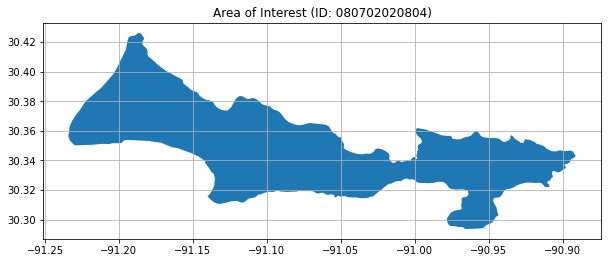

In [6]:
gdf11 = gdf.loc[gdf[filter_field] == select_data].copy()
    
geo_df = gdf11.to_crs(epsg = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

In [ ]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [ ]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [ ]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

#Added by Mark Bartlett 
#Parse out the file name by using split functions
for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

### Iterate through zip files and build a table:

In [ ]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [ ]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save:

In [ ]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
    print(table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(filter_field) + '_' + str(select_data)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.save()

---